## Welcome

This is material for the **Potential Outcomes** chapter in Scott Cunningham's book, [Causal Inference: The Mixtape.](https://mixtape.scunning.com/)

In [7]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from itertools import combinations
import plotnine as p

In [4]:
# read data
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

def read_data(file):
    return pd.read_stata("https://raw.github.com/scunning1975/mixtape/master/" + file)

In [9]:
yule = read_data('yule.dta')

res = sm.OLS.from_formula('paup ~ outrelief + old + pop', yule).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   paup   R-squared:                       0.697
Model:                            OLS   Adj. R-squared:                  0.665
Method:                 Least Squares   F-statistic:                     21.49
Date:                Wed, 10 Mar 2021   Prob (F-statistic):           2.00e-07
Time:                        17:53:45   Log-Likelihood:                -115.47
No. Observations:                  32   AIC:                             238.9
Df Residuals:                      28   BIC:                             244.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     63.1877     27.144      2.328      0.027       7.586     118.789
outrelief      0.7521      0.135      5.572      0.000       0.476       1.029
old            0.0556      0.223      0.249      0.805      -0.402       0.513
pop           -0.3107      0.067     -4.648      0.000      -0.448      -0.174
==============================================================================
Omnibus:                        7.594   Durbin-Watson:                   2.344
Prob(Omnibus):                  0.022   Jarque-Bera (JB):                5.979
Skew:                           0.961   Prob(JB):                       0.0503
Kurtosis:                       3.888   Cond. No.                     2.56e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.56e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Questions

- How do you interpret the coefficient on `outrelief` given it's a percentage change regressed onto a percentage?
- Draw a DAG representing what must be true in order for Yule's estimate of `outrelief` on pauper growth rates to be causal?  
- Yule concluded that public assistance (`outrelief`) increased pauper growth rates. How convinced are you that all backdoor paths between pauperism and out-relief are blocked once you control for two covariates in a cross-sectional database for all of England? Could there be unobserved determinants of both poverty and public assistance?
- If public assistance causes pauper growth rates, but pauper growth rates also causes public assistance, then why won't Yule's regression capture a causal effect of `outrelief` on pauper growth rates?  Explain the concept of reverse causality with Yule's data.

In [12]:
## Independence Assumption

In [10]:
def gap():
    sdo = pd.DataFrame({
        'y1': (7, 5, 5, 7, 4, 10, 1, 5, 3, 9),
        'y0' : (1, 6, 1, 8, 2, 1, 10, 6, 7, 8),
        'random' : np.random.normal(size=10)})
    sdo.sort_values('random', inplace=True)
    sdo['d'] = [1,1,1,1,1,0,0,0,0,0]
    sdo['y'] = sdo['d']*sdo['y1'] + (1-sdo['d'])*sdo['y0']

    sdo = np.mean(sdo.y.values[0:5] - sdo.y.values[5:10])

    return sdo


sim = [gap() for x in range(1000)]
np.mean(sim)

0.6176

#### Questions
- The requirement that treatment be independent of potential outcomes states that a choice made by a person must be independent of what they expect to gain or lose from the choice.  Give an example where this is likely true?  What does independence imply about human decision-making?
- All of the behavioral sciences, including economics, suggest that independence is unlikely to hold outside of an experiment. What is so special about an experiment where independence will hold?  What is so special about behavior outside an experiment where it is unlikely to hold?
- What implication does the decision rule of utility maximization from economics have for our ability to appeal to treatment being distributed independent of potential outcomes?





## Fisher Randomization

In [13]:
correct = pd.DataFrame({'cup': np.arange(1,9), 
                        'guess':np.concatenate((range(1,5), np.repeat(0, 4)))})

combo = pd.DataFrame(np.array(list(combinations(correct['cup'], 4))), 
                     columns=['cup_1', 'cup_2', 'cup_3', 'cup_4'])
combo['permutation'] = np.arange(70)
combo['key'] = 1
correct['key'] = 1
combo = pd.merge(correct, combo, on='key')
combo.drop('key', axis=1, inplace=True)
combo['correct'] = 0
combo.loc[(combo.cup_1==1) & 
          (combo.cup_2==2) & 
          (combo.cup_3==3) & 
          (combo.cup_4==4), 'correct'] = 1
combo = combo.sort_values(['permutation', 'cup'])

p_value = combo.correct.sum()/combo.shape[0]
p_value

0.014285714285714285

#### Questions

- Using the above simulation, what is the probability that Dr. Bristol selected the correct four cups completely by chance?

## Randomization Inference

### Fisher Sharp Null

In [16]:
ri = read_data('ri.dta')
ri['id'] = range(1,9)
treated = range(1,5)

combo = pd.DataFrame(np.array(list(combinations(ri['id'], 4))), 
                     columns=['treated1', 'treated2', 'treated3', 'treated4'])
combo['permutation'] = np.arange(1,71)

combo['key'] = 1
ri['key'] = 1
combo = pd.merge(ri, combo, on='key')
combo.drop('key', axis=1, inplace=True)
combo = combo.sort_values(['permutation', 'name'])

combo['d'] = 0
combo.loc[(combo.treated1==combo.id) | 
          (combo.treated2==combo.id) | 
          (combo.treated3==combo.id) | 
          (combo.treated4==combo.id), 'd'] = 1

te1 = combo[combo.d==1].groupby('permutation')['y'].mean()
te0 = combo[combo.d==0].groupby('permutation')['y'].mean()

n = pd.merge(te1, te0, how='inner', on="permutation").shape[0]

p_value = pd.merge(te1, te0, how='inner', on="permutation")
p_value.columns = ['te1', 'te0']
p_value = p_value.reset_index()
p_value['ate'] = p_value['te1'] - p_value['te0']
p_value = p_value.sort_values(by='ate', ascending=False)
p_value['rank'] = range(1, p_value.shape[0]+1)
p_value = p_value[p_value['permutation'] == 1]
p_value['rank'] / n

0    0.371429
Name: rank, dtype: float64


#### Questions

- Can we reject the null in the placebo distribution?



### KS Test


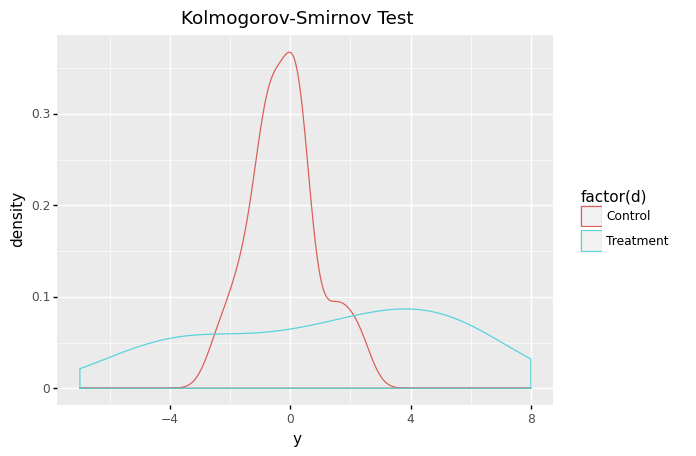

<ggplot: (8762754256388)>

In [17]:
tb = pd.DataFrame({
    'd' : np.concatenate((np.repeat(0, 20), np.repeat(1, 20))),
    'y' : (
        0.22, -0.87, -2.39, -1.79, 0.37, -1.54,
        1.28, -0.31, -0.74, 1.72,
        0.38, -0.17, -0.62, -1.10, 0.30,
        0.15, 2.30, 0.19, -0.50, -0.9,
        -5.13, -2.19, 2.43, -3.83, 0.5,
        -3.25, 4.32, 1.63, 5.18, -0.43,
        7.11, 4.87, -3.10, -5.81, 3.76,
        6.31, 2.58, 0.07, 5.76, 3.50
    )})

p.ggplot() +\
    p.geom_density(tb, p.aes(x='y', color='factor(d)')) +\
    p.xlim(-7, 8) +\
    p.labs(title = "Kolmogorov-Smirnov Test") +\
    p.scale_color_discrete(labels = ("Control", "Treatment"))

## Approximate $p$-values

In [18]:
hiv = read_data("thornton_hiv.dta")
# creating the permutations

def permuteHIV(df, random = True):
    tb = df.copy()
    first_half = np.ceil(tb.shape[0] / 2)
    second_half = tb.shape[0] - first_half
    if random:
        tb = tb.sample(frac=1)
        tb['any'] = np.concatenate((np.repeat(1, first_half), np.repeat(0, second_half)))
    
    te1 = tb[tb['any']==1]['got'].mean()
    te0 = tb[tb['any']==0]['got'].mean()
    
    
    ate = te1 - te0
    return ate

print(permuteHIV(hiv, random = False))
iterations = 1000
permutation = pd.DataFrame({
    'iteration': range(iterations),
    'ate' : [permuteHIV(hiv, random=False), 
                            *[permuteHIV(hiv, random=True) for x in range(iterations-1)]]}
)
# calculating the p-value

permutation = permutation.sort_values('ate', ascending=False)
permutation['rank'] = np.arange(1, iterations+1)
p_value = permutation[permutation.iteration==0]['rank'].astype(float) / iterations
print(p_value)

0.45055187
0    0.001
Name: rank, dtype: float64


#### Questions 

- How does the randomization inference test of no treatment effect differ from a null of no average treatment effect?
- How likely is it that Thornton's results were a result of random chance? 